In [2]:
import cv2
# import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
# import matplotlib.pyplot as plt
# from segpy.dataset import Dataset
import logging
from pathlib import Path
from scipy import signal
import toml
from PIL import Image, ImageOps
import datetime 
logger = logging.getLogger(__name__)
import os
from scipy.signal import butter, lfilter, freqz

from image2segy_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\rawimages\\'
files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.png',
      'test.png',
       '0045_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-103_crop.png',
       '0049_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-111_crop.png'
#        '0128_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ B-129_crop.png'
      ]

# files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.jpg']

# viennadf=pd.read_excel(datafolder+'Data List from JOGMEC_June2022.xlsx','Vietnam', skiprows=[0])
file=files[-1]

In [88]:
image = cv2.imread(datafolder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sgray=gray.sum(axis=1)

print(file,gray.shape)

0049_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-111_crop.png (4076, 22117)


(2740.0, 3099.0)

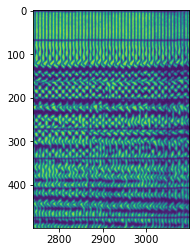

In [92]:
fig=plt.figure(figsize=(18,4))
plt.imshow(gray[:500,0:5000])
xlim=[2740,  3099]
plt.xlim(xlim)

In [93]:
th3 = cv2.adaptiveThreshold(gray[25:50,:],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,15).astype(float)
th3[th3>0]=-1
th3[th3==0]=1

(0.0, 200.0)

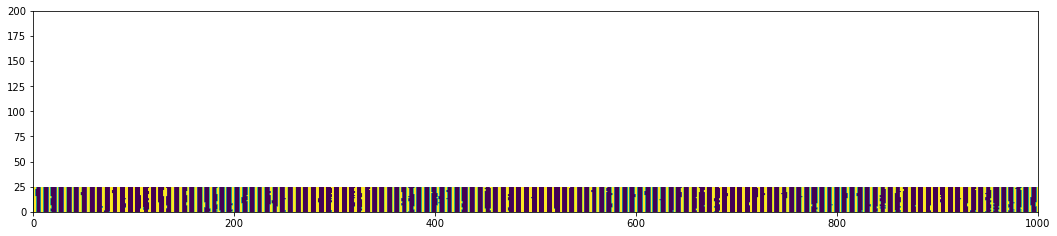

In [94]:
fig=plt.figure(figsize=(18,16))
plt.imshow(th3[:,0:5000])
xlim=[0,1000]
ylim=[0,200]
plt.xlim(xlim)
plt.ylim(ylim)

(0.0, 1000.0)

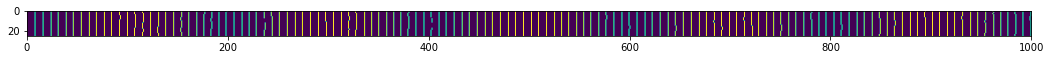

In [95]:
vert_len=5
hor_len=2
kernel1 = np.hstack([np.ones((vert_len, hor_len), np.float32)*-1,np.ones((vert_len, hor_len), np.float32)])
kernel1
img = cv2.filter2D(src=th3, ddepth=-1, kernel=kernel1)
thresh=vert_len*(hor_len+1)
img[img<thresh]=0
img[img>=thresh]=1
img[img==0]=-1
fig=plt.figure(figsize=(18,4))
plt.imshow(img)
plt.xlim(xlim)
# plt.ylim(ylim)

(0.0, 1000.0)

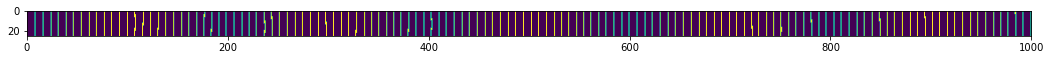

In [96]:
vert_len=10
hor_len=1
img2=np.copy(img)

kernel2 = np.hstack([np.ones((vert_len, hor_len), np.float32)*-1,np.ones((vert_len, hor_len), np.float32)*2
                    ,np.ones((vert_len, hor_len), np.float32)*-1])
for i in range(3):
    img2 = cv2.filter2D(src=img2, ddepth=-1, kernel=kernel2)
    thresh=vert_len*hor_len/2
    img2[img2<thresh]=0
    img2[img2>=thresh]=1
    img2[img2==0]=-1
fig=plt.figure(figsize=(18,16))
plt.imshow(img2)
plt.xlim(xlim)

(2740.0, 3099.0)

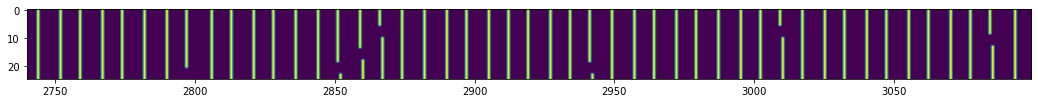

In [102]:
vert_len=5
hor_len=1
kernel1 = np.hstack([np.ones((vert_len, hor_len), np.float32)*-1,np.ones((vert_len, hor_len), np.float32)])
kernel1
img3 = cv2.filter2D(src=img2, ddepth=-1, kernel=kernel1)
thresh=vert_len*(hor_len+1)
img3[img3<thresh]=0
img3[img3>=thresh]=1
img3[img3==0]=-1
fig=plt.figure(figsize=(18,4))
plt.imshow(img3)
xlim=[2740,  3099]
plt.xlim(xlim)

(array([ 1,  5,  6,  7,  8,  9, 14, 16], dtype=int64),
 array([ 739,    1,   85, 1874,  958,    4,    1,    1], dtype=int64))

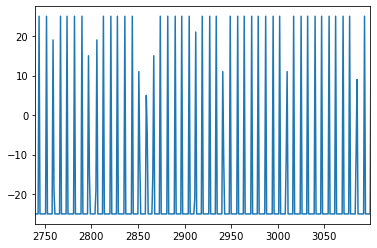

In [103]:
# plt.hist(img2.ravel())
imsum=img.sum(axis=0)
plt.plot(imsum)
xlim=[2740,  3099]
plt.xlim(xlim)
idxs=np.where(imsum>np.min(imsum))[0]
diffidxs=np.diff(idxs)
ab=np.unique(diffidxs,return_counts =True)
ab

(array([ 7,  8,  9, 14, 15, 16, 22, 23], dtype=int64),
 array([1201, 1433,   18,    8,   99,   19,    1,    6], dtype=int64))

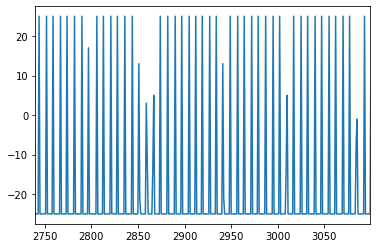

In [104]:
# plt.hist(img2.ravel())
imsum=img3.sum(axis=0)
plt.plot(imsum)
xlim=[2740,  3099]
plt.xlim(xlim)
idxs=np.where(imsum>0)[0]
diffidxs=np.diff(idxs)
ab=np.unique(diffidxs,return_counts =True)
ab

In [105]:
didxs=np.where(diffidxs>15)[0]
didxs
# idxs
idxs[didxs]
# diffidxs[didxs]
# idxs[0],didxs[0]

array([  100,  1393,  2412,  3077,  3123,  3184,  4279,  4454,  6607,
        6887,  8678,  8993,  9137,  9690,  9901, 12029, 12142, 12209,
       13343, 13999, 14053, 14551, 14975, 18992, 20553, 21669],
      dtype=int64)

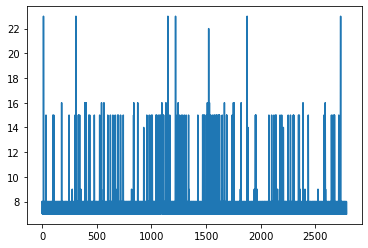

In [106]:
plt.plot(diffidxs)
pixpertrace=np.median(diffidxs)

In [107]:
img2.shape[1]/pixpertrace,pixpertrace

(2764.625, 8.0)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 14, 22], dtype=int64),
 array([  79,    1,    1,    2,    5,  332, 2234,  330,    1,    3,    6,
           1], dtype=int64))

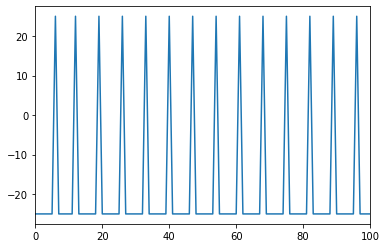

In [39]:
# plt.hist(img2.ravel())
imsum=img2.sum(axis=0)
plt.plot(imsum)
plt.xlim(xlim)
idxs=np.where(imsum>0)
diffidxs=np.diff(idxs)
ab=np.unique(diffidxs,return_counts =True)
ab

In [115]:
# ap=[('tert',(4,5)),('art',(40,50))]
# type(ap[0])
# ap[0][0]='pert'
coordfor='tye'
coordinatefor=coordfor if type(coordfor)==str else str(coordfor)
coordinatefor

'tye'

(0.0, 100.0)

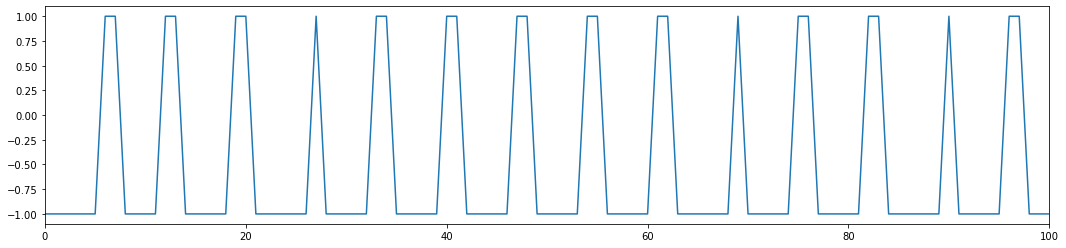

In [23]:
mim=th3[:,:1000].copy()


smim=mim.sum(axis=0)
smim[smim<0]=-1
smim[smim>0]=1
fig=plt.figure(figsize=(18,4))
plt.plot(smim)
xlim=[0,100]
# ylim=[0,200]
plt.xlim(xlim)
# plt.ylim(ylim)